In [1]:
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append('../')
from neuralop.utils import count_model_params
from neuralop import LpLoss, H1Loss
import copy

import numpy as np
from timeit import default_timer
import torch.nn.functional as F
import torch.nn as nn
from utils.losses import EnergyScore, KernelScore, VariogramScore
from models.fno import FNO2d
from models.pfno import PFNO_Wrapper
#from models.laplace import LA_Wrapper
from models.mcdropout import generate_mcd_samples
from data.datasets import DarcyFlowDataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataloaders

In [20]:
batch_size = 32
n_samples = 100 # Samples to create from predictive distributions

In [3]:
data_dir = "../data/DarcyFlow/processed/"
train_data = DarcyFlowDataset(data_dir, test = False, downscaling_factor=2)
test_data = DarcyFlowDataset(data_dir, test = True)

train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True)

n_train = train_data.__len__()
n_test = test_data.__len__()

## Visualize samples

Text(0, 0.5, 'Darcy flow solution')

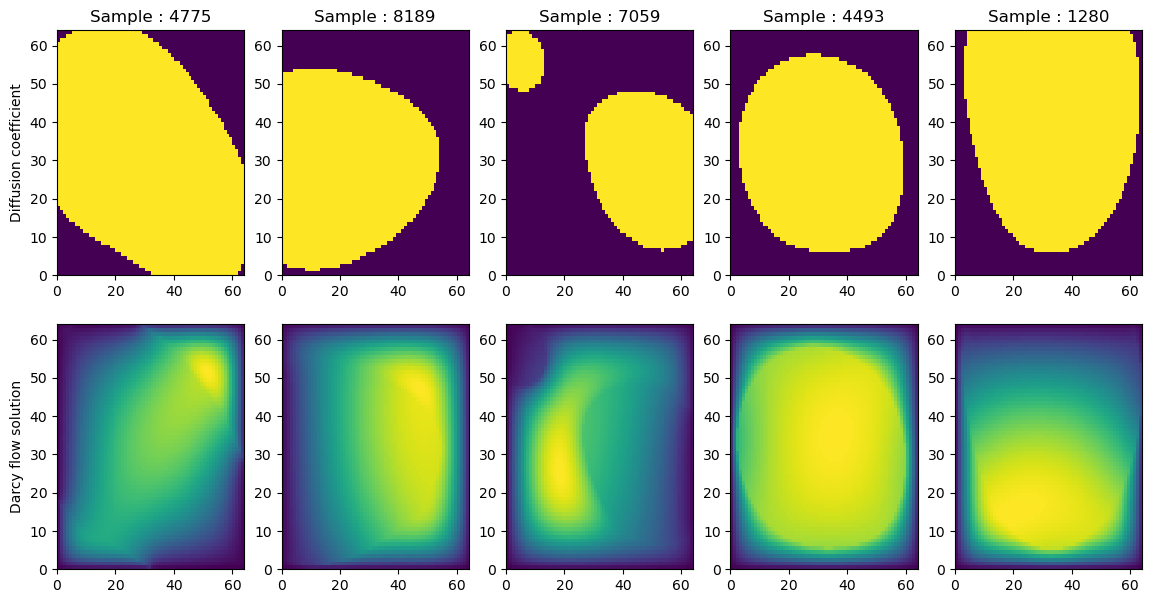

In [4]:
samples = np.random.randint(0, train_data.__len__(),5)

fig, axs = plt.subplots(2, 5, figsize=(14, 7))
for s, sample in enumerate(samples):
    a,u = train_data.__getitem__(sample)
    axs[0,s].pcolormesh(a[0])
    axs[1,s].pcolormesh(u[0])
    axs[0,s].set_title(f"Sample : {sample}")
axs[0, 0].set_ylabel(f"Diffusion coefficient")
axs[1, 0].set_ylabel(f"Darcy flow solution")

# Losses and parameters

In [5]:
# Losses and parameters
l2loss = LpLoss(d=2, p=2, L = 10.0)
energy_score = EnergyScore(d = 2, p = 2, type = "lp", L = 10.0)

# Training parameters
epochs = 5
learning_rate = 0.001
dropout_rate = 0.1
weight_decay = 10e-4

# Train base model

In [39]:
dropout_model = FNO2d(n_modes=(16,16), hidden_channels=32, in_channels = 3, dropout_rate=dropout_rate, lifting_channels = 64, projection_channels = 64)
dropout_model = dropout_model.to(device)

n_params = count_model_params(dropout_model)
print(f'\nOur model has {n_params} parameters.')
sys.stdout.flush()



Our model has 4203041 parameters.


In [7]:
optimizer = torch.optim.Adam(dropout_model.parameters(),lr=learning_rate, weight_decay=weight_decay)

In [8]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    dropout_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)

        optimizer.zero_grad()
        out = dropout_model(a)
        
        l2 = l2loss(out.view(batch_size, -1), u.view(batch_size, -1))
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    dropout_model.eval()
    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            a, u = sample
            a = a.to(device)
            u = u.to(device)

            out = dropout_model(a)
            test_l2 += l2loss(out.view(batch_size, -1), u.view(batch_size, -1)).item()

    train_l2 /= n_train
    test_l2 /= n_test
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-57.1227, Train-L2-0.0108, Test-L2-0.0068


# MC Dropout

In [21]:
dropout_model.train()
""" Prediction """
mse_dropout = 0
es_dropout = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        out = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        mse_dropout += l2loss(out.mean(axis = -1).view(batch_size, -1), u.view(batch_size, -1)).item() / n_test
        es_dropout += energy_score(out, u).item() / n_test


print('MSE:', mse_dropout)
print('ES:', es_dropout)

MSE: 0.006625862032175063
ES: 0.00878720822930336


# Laplace approximation

In [22]:
u.shape

torch.Size([8, 1, 128, 128])

# PFNO

In [23]:
hidden_model = FNO2d(n_modes=(16,16), hidden_channels=32, in_channels = 3, dropout_rate=dropout_rate, lifting_channels = 64, projection_channels = 64)
pfno_model = PFNO_Wrapper(hidden_model, n_samples = 3)

#pfno_model = PFNO_Wrapper(copy.deepcopy(dropout_model), n_samples = 3)
pfno_model.to(device)
# Model and optimizer
optimizer = torch.optim.Adam(pfno_model.parameters(), lr = learning_rate, weight_decay = weight_decay)

In [24]:
train_loss = torch.zeros(epochs)
test_loss = torch.zeros(epochs)

for ep in range(epochs):
    pfno_model.train()
    t1 = default_timer()
    train_l2 = 0
    for sample in train_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)

        optimizer.zero_grad()
        out = pfno_model(a)
        
        l2 = energy_score(out,u)
        l2.backward() # l2 relative loss

        optimizer.step()
        train_l2 += l2.item()

    test_l2 = 0.0
    with torch.no_grad():
        for sample in test_loader:
            a, u = sample
            a = a.to(device)
            u = u.to(device)

            out = pfno_model(a)
            test_l2 += energy_score(out,u)

    train_l2 /= n_train
    test_l2 /= n_test
    
    train_loss[ep] = train_l2
    test_loss[ep] = test_l2

    t2 = default_timer()
    print('Epoch-{}, Time-{:0.4f}, Train-L2-{:0.4f}, Test-L2-{:0.4f}'
          .format(ep, t2-t1, train_l2, test_l2))

Epoch-0, Time-63.6232, Train-L2-0.0128, Test-L2-0.0105


In [25]:
pfno_model.train()
""" Prediction """
mse_pfno = 0
es_pfno = 0
with torch.no_grad():    
    index = 0
    for sample in test_loader:
        a, u = sample
        a = a.to(device)
        u = u.to(device)
        out = pfno_model(a, n_samples = n_samples)
        mse_pfno += l2loss(out.mean(axis = -1).view(batch_size, -1), u.view(batch_size, -1)).item() / n_test
        es_pfno += energy_score(out, u).item() / n_test


print('MSE:', mse_pfno)
print('ES:', es_pfno)

MSE: 0.008409120038151741
ES: 0.010508021906018258


# Metric comparison

In [26]:
print(f"Dropout \nMSE: {mse_dropout} \t ES: {es_dropout}")
print(f"PFNO \nMSE: {mse_pfno} \t ES: {es_pfno}")

Dropout 
MSE: 0.006625862032175063 	 ES: 0.00878720822930336
PFNO 
MSE: 0.008409120038151741 	 ES: 0.010508021906018258


# Visualizations

In [27]:
samples = np.random.randint(0,n_test,5)

pfno_model.train()
dropout_model.train()
""" Prediction """
pred_pfno = []
pred_dropout = []

with torch.no_grad():    
    index = 0
    for sample in samples:
        a,u = test_data.__getitem__(sample)
        a = a.to(device).unsqueeze(0)
        u = u.to(device).unsqueeze(0)
        dropout_pred = generate_mcd_samples(dropout_model, a, u.shape, n_samples=n_samples)
        pfno_pred = pfno_model(a, n_samples = n_samples)

        pred_dropout.append( dropout_pred )
        pred_pfno.append( pfno_pred )


pred_pfno = torch.cat(pred_pfno, dim = 0)
pred_dropout = torch.cat(pred_dropout, dim = 0)


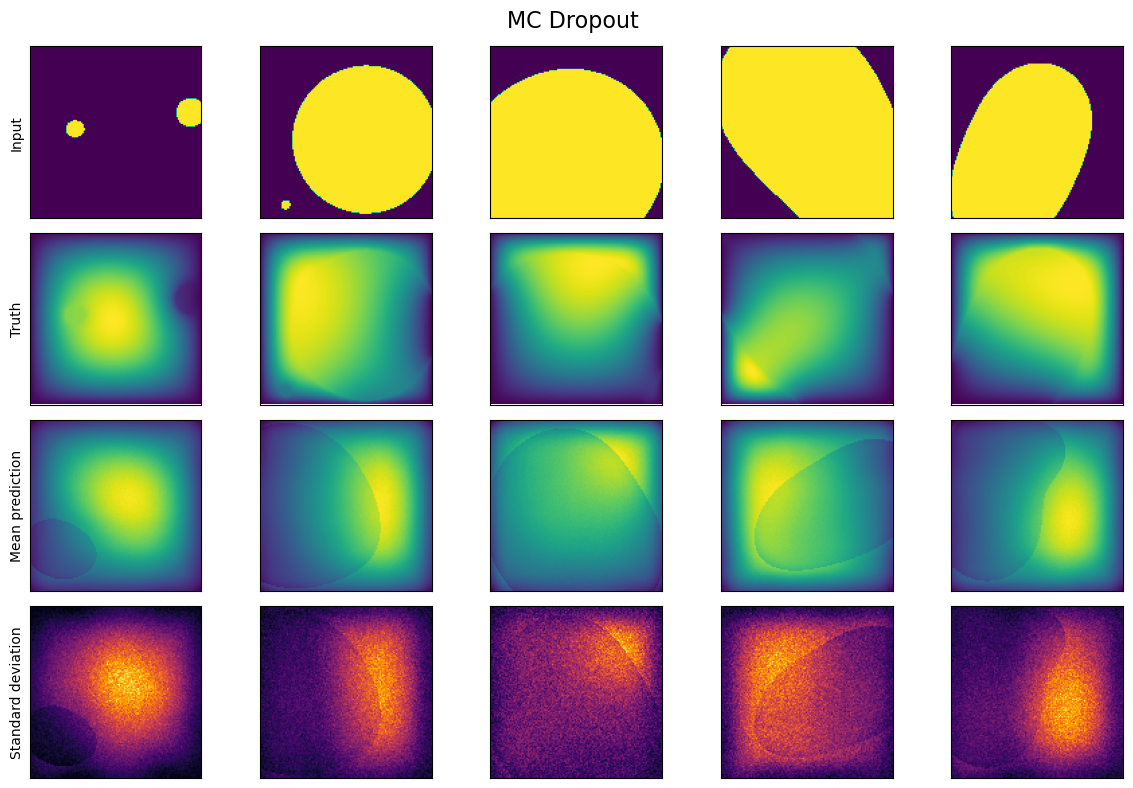

In [30]:
n_samples = np.random.randint(0,n_test,5)

""" Plotting """ 
fig, axs = plt.subplots(4, 5, figsize = (12, 8))
index = 0
for i, sample in enumerate(n_samples):
        a,u = test_data.__getitem__(sample)
        axs[0,i].imshow(a[0].cpu().numpy())
        axs[1,i].imshow(u[0].cpu().numpy())
        axs[2,i].imshow(pred_dropout[i,0].cpu().numpy().mean(axis = -1))
        axs[3,i].imshow(pred_dropout[i,0].cpu().numpy().std(axis = -1), cmap = "inferno")

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0)

axs[0,0].set_ylabel('Input')
axs[1,0].set_ylabel('Truth')
axs[2,0].set_ylabel('Mean prediction')
axs[3,0].set_ylabel('Standard deviation')
fig.suptitle('MC Dropout', fontsize=16)

fig.tight_layout()

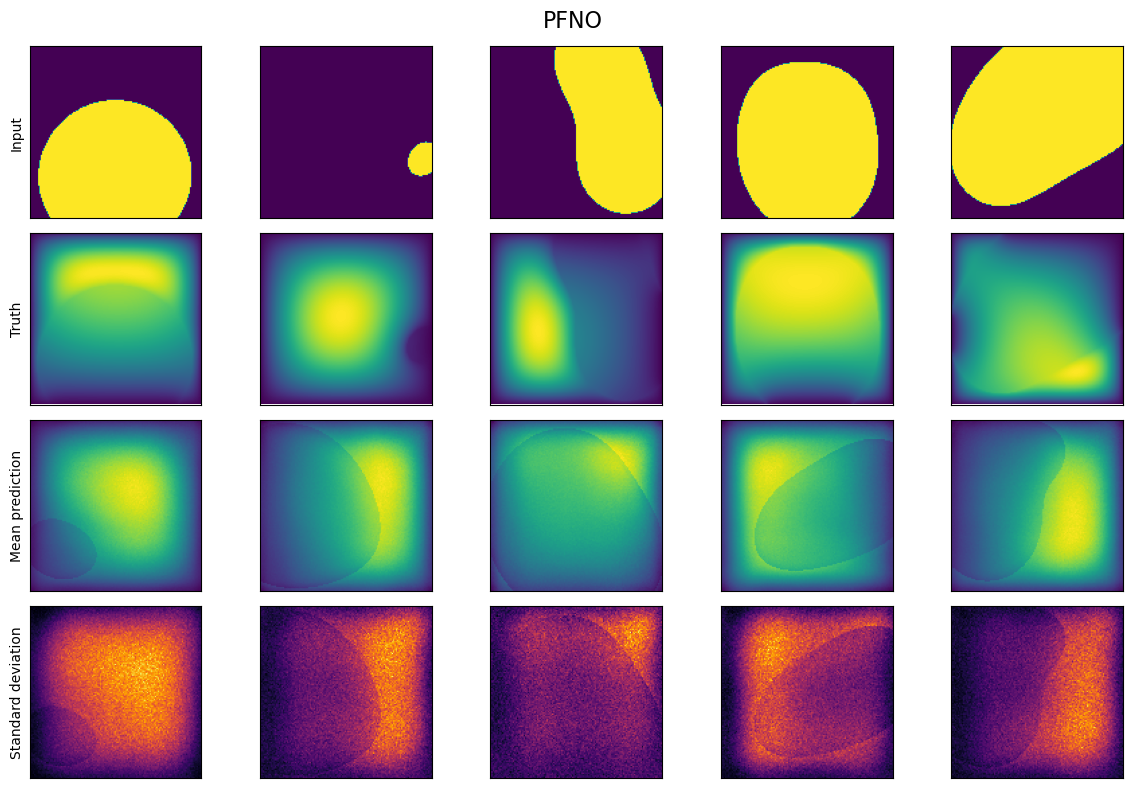

In [31]:
n_samples = np.random.randint(0,n_test,5)

""" Plotting """ 
fig, axs = plt.subplots(4, 5, figsize = (12, 8))
index = 0
for i, sample in enumerate(n_samples):
        a,u = test_data.__getitem__(sample)
        axs[0,i].imshow(a[0].cpu().numpy())
        axs[1,i].imshow(u[0].cpu().numpy())
        axs[2,i].imshow(pred_pfno[i,0].cpu().numpy().mean(axis = -1))
        axs[3,i].imshow(pred_pfno[i,0].cpu().numpy().std(axis = -1), cmap = "inferno")

for ax in axs.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
    ax.margins(0)

axs[0,0].set_ylabel('Input')
axs[1,0].set_ylabel('Truth')
axs[2,0].set_ylabel('Mean prediction')
axs[3,0].set_ylabel('Standard deviation')
fig.suptitle('PFNO', fontsize=16)

fig.tight_layout()